In [7]:
import numpy as np
import scipy.stats as sps
from tqdm import tqdm
import matplotlib.pyplot as plt

# STATS 370
## Final project

In [8]:
# read in data
data = np.genfromtxt('data.csv', delimiter=',', skip_header=1, usecols=(1,2,3))
groups = data[:,0].astype(int)
Y = data[:, 1:]

In [9]:
# define un-normalized posterior
def prob_post(theta, Y, groups):
    
    # unravel theta
    ss, tau, mu1, mu2, gam1, gam2 = theta
    mu = np.array((mu1, mu2))
    gam = np.array((gam1, gam2))
    
    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()
    
    # make mean vector
    mean_set = [mu, gam, (mu + gam)/2, tau*mu + (1-tau)*gam]
    means = []
    for n_i, mean_i in zip(ns, mean_set):
        for i in range(n_i):
            means += [mean_i]
    means = np.array(means)
    
    # sum of squares
    sum_squares = np.sum(np.square(Y - means))
    
    # calculate unscaled p
    p = (1/ss)**(n+1) * np.exp((-1/(2*ss)) * sum_squares)
    return p

In [10]:
gam_a = 0.5
gam_s = 0.25
norm_s = .005

def value_cand(theta):
    x = np.concatenate(([
        sps.gamma.rvs(a=gam_a, scale=gam_s), 
        sps.uniform.rvs(loc=0, scale=1)],
        sps.multivariate_normal.rvs(mean=theta[2:], cov=norm_s)))
    return x

def prob_cand(x, theta):
    p = (sps.gamma.pdf(x=x[0], a=gam_a, scale=gam_s) * 
         sps.uniform.pdf(x=x[1], loc=0, scale=1) * 
         sps.multivariate_normal.pdf(x=x[2:], mean=theta[2:], cov=norm_s))
    return p

In [35]:
T = 100000
xt = []
cands = []
status = []

# Initialize then iterate
x0 = np.array((0.25, 0.5, 0, 0, 0, 0))
x = x0

for t in tqdm(range(T)):
    # 1. propose candidate according to candidate distribution
    cand = value_cand(theta=x)
    
    # 2. Calculate acceptance probability
    post_ratio = prob_post(theta=cand, Y=Y, groups=groups) / prob_post(theta=x, Y=Y, groups=groups)
    cand_ratio = prob_cand(x=x, theta=cand) / prob_cand(x=cand, theta=x)
    prob_accept = np.minimum(1, post_ratio*cand_ratio)
    
    # 3. Accept or reject
    u = sps.uniform.rvs(loc=0, scale=1)
    if u <= prob_accept:
        cands += [cand]
        status += ['a']
        x = cand
        xt += [cand]
    else:
        cands += [cand]
        xt += [x]
        status += ['r']

xt = np.array(xt)
cands = np.array(cands)
status = np.array(status)

100%|██████████████████████████████████| 100000/100000 [01:42<00:00, 971.47it/s]


## Plot results

In [36]:
def plot_ar(cands, status):
    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))

    # plot rejections
    ix = np.where(status == 'r')
    ax[0].scatter(cands[ix, 0], cands[ix, 1], color='red', label='reject', alpha=0.6)
    ax[1].scatter(cands[ix, 2], cands[ix, 3], color='red', label='reject', alpha=0.6)
    ax[2].scatter(cands[ix, 4], cands[ix, 5], color='red', label='reject', alpha=0.6)
    # plot acceptances
    ix = np.where(status == 'a')
    ax[0].scatter(cands[ix, 0], cands[ix, 1], color='blue', label='accept', alpha=0.6)
    ax[1].scatter(cands[ix, 2], cands[ix, 3], color='blue', label='accept', alpha=0.6)
    ax[2].scatter(cands[ix, 4], cands[ix, 5], color='blue', label='accept', alpha=0.6)

    ax[0].set(xlabel='ss', ylabel='tau')
    n_accept = (status == 'a').sum()
    ax[1].set(xlabel='mu1', ylabel='mu2', title=f'n accept: {n_accept} ({n_accept / len(status):0.2%})')
    ax[2].set(xlabel='gam1', ylabel='gam2')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.show()

In [37]:
def plot_marginals(xt):
    theta_labels = ['ss', 'tau', 'mu1', 'mu2', 'gam1', 'gam2']
    fig, ax = plt.subplots(ncols=2, figsize=(18, 6), sharey=True, width_ratios=[3,1])

    for i in range(xt.shape[1]):
        ax[0].plot(xt[:,i], alpha=0.75, label=theta_labels[i])
        ax[1].hist(xt[:,i], alpha=0.5, density=True, bins=40, orientation='horizontal', label=theta_labels[i])

    ax[1].legend()
    ax[0].set(xlabel='iteration', title='samples')
    ax[1].set(title='marginal densities')
    plt.show()

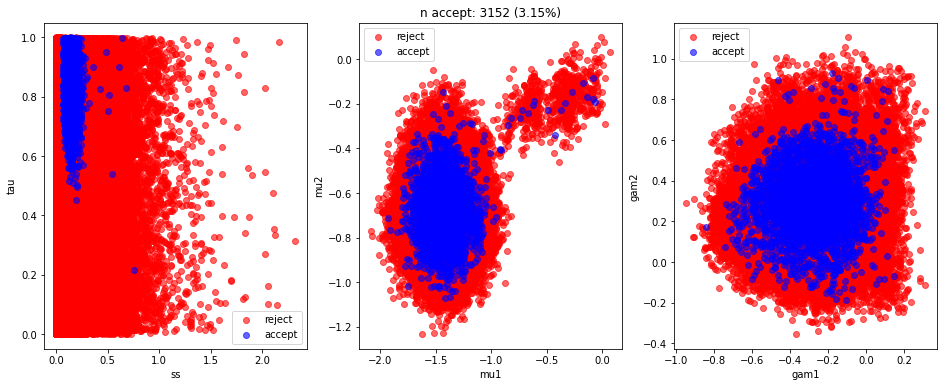

In [38]:
plot_ar(cands, status)

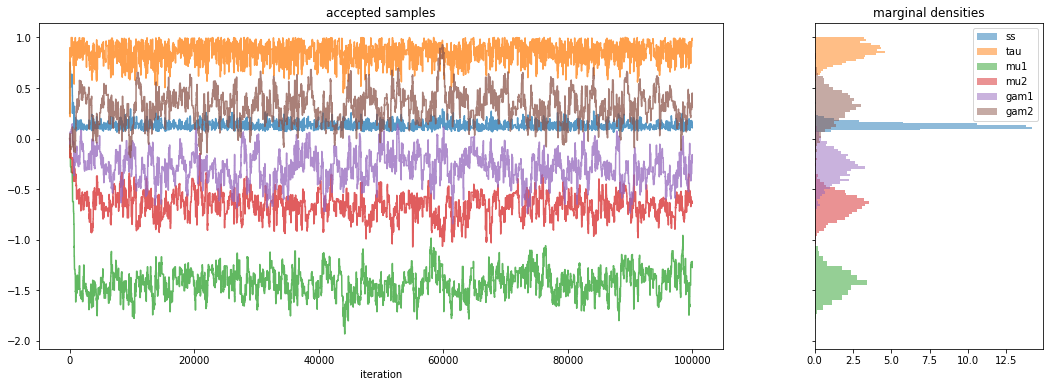

In [39]:
plot_marginals(xt)